# FashionMNIST VAE

  Using cached https://files.pythonhosted.org/packages/35/d9/360f4483f735cbd4f1ac7316f3bdbee06b5872355963b913f1a53871ac72/pprofile-2.0.2.tar.gz
  Running setup.py bdist_wheel for pprofile ... done
  Stored in directory: /home/jupyter/.cache/pip/wheels/e6/09/3f/d834c2f19fd7f80e5f5369b5372485ca044efba8ea1742888f
Successfully built pprofile
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#%pip install torch

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from helper_functions import *



### Define the simulation parameters

In [8]:
params = { 
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28, 
    'DIM_Z':2,
    'SCALE': 1000.0,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'HEIGHT': 28, 'SCALE': 1000.0, 'WIDTH': 28, 'DIM_Z': 2, 'CHANNELS': 1, 'use_cuda': True}


### Get the data

torch.Size([512, 1, 28, 28])


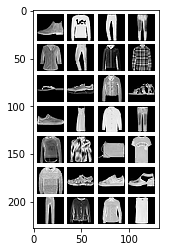

In [9]:
BATCH_SIZE = 512
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}
data_dir = "/home/jupyter/REPOS/VAE_PYRO"

trainset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:28],npadding=4)

### Instantiate VAE class 
This is the case without latent structure

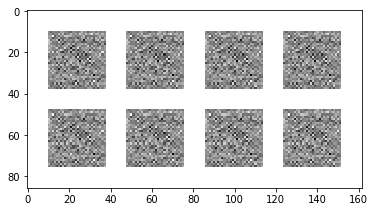

In [10]:
from encoder_decoder import *
from vae import *

#encoder = Encoder_MLP(params)
#decoder = Decoder_MLP(params)
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

vae.guide()
vae.model()
if(params['use_cuda']):
    imgs=imgs.cuda()
imgs_rec = vae.reconstruct(imgs)
show_batch(imgs_rec[:8])

In [11]:
### test_model(vae.model,vae.guide,Trace_ELBO())
### 
### #load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")
### 
### import pyro.poutine as poutine
### #
### print("----MODEL---------")
### trace = poutine.trace(vae.model).get_trace()
### trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
### print(trace.format_shapes())
### #
### print("----GUIDE ---------")
### trace = poutine.trace(vae.guide).get_trace()
### trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
### print(trace.format_shapes())

In [12]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# setup the optimizer
optimizer = Adamax({"lr": 1.0e-3, "betas":(0.9, 0.999)})
#optimizer = RMSprop({"lr": 1.0e-4})



svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
train_loss, test_loss = [], []
min_loss = 999999

In [13]:
#write_dir  = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'
write_dir = "/home/jupyter/REPOS/VAE_PYRO/ARCHIVE/"

descriptor      = "Fashion_MNIST_scale_1000.0"
descriptor      = "Fashion_TEST"
name_vae        = "vae_"+descriptor+"_"
name_train_loss = "train_loss_"+descriptor+"_"
name_test_loss  = "test_loss_"+descriptor+"_"
name_params     = "params_"+descriptor


save_obj(params,write_dir,name_params)

# PROFILE THE CODE

In [14]:
#%pip install pprofile
import pprofile

In [15]:
# training loop

prof = pprofile.Profile()
with prof():
        
    #for epoch in range(0,NUM_EPOCHS):
    for epoch in range(0,2
                      ):
        vae.train()            
        
        loss = train(svi,trainloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
        train_loss.append(loss)   
        print("[epoch %03d] train loss: 
              
              
              %.4f" % (epoch, loss))
        
        if(epoch % TEST_FREQUENCY == 0):
            vae.eval()
            loss = evaluate(svi,testloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
            test_loss.append(loss)
        
            if(test_loss[-1] < min_loss):
                print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
                min_loss = test_loss[-1]
                #### Save if you got a record 
                ###save_model(vae,write_dir,name_vae+str(epoch))       
                ###save_obj(test_loss,write_dir,name_test_loss+str(epoch))
                ###save_obj(train_loss,write_dir,name_train_loss+str(epoch))
            else:
                print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
                
        if(epoch % WRITE_FREQUENCY == 0):
            save_model(vae,write_dir,name_vae+str(epoch))       
            save_obj(test_loss,write_dir,name_test_loss+str(epoch))
            save_obj(train_loss,write_dir,name_train_loss+str(epoch))
prof.print_stats()

loss=5595979.50000
loss=4140445.37500
loss=2810270.62500
loss=2253123.25000
loss=2203404.00000
loss=2100830.12500
loss=1935528.37500
loss=1777192.62500
loss=1684641.12500
loss=1582269.50000
loss=1618866.37500
loss=1587746.12500
loss=1540977.37500
loss=1452143.50000
loss=1570874.12500
loss=1447597.12500
loss=1500027.75000
loss=1403213.75000
loss=1472370.25000
loss=1468605.50000
loss=1396159.87500
loss=1383273.25000
loss=1414868.25000
loss=1342069.75000
loss=1349296.75000
loss=1272913.75000
loss=1346772.37500
loss=1327965.12500
loss=1376045.12500
loss=1376753.62500
loss=1328802.00000
loss=1329014.62500
loss=1283053.50000
loss=1319793.37500
loss=1285430.50000
loss=1263105.62500
loss=1218541.62500
loss=1226206.87500
loss=1245985.87500
loss=1230372.00000
loss=1215803.37500
loss=1202403.25000
loss=1239823.25000
loss=1184469.00000
loss=1177751.62500
loss=1205091.12500
loss=1194885.00000
loss=1198401.00000
loss=1157420.12500
loss=1167466.75000
loss=1176382.00000
loss=1198587.75000
loss=1165979

# Check the results

In [ ]:
#write_dir = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'

#descriptor      = "MNIST_v1"

#load_model(vae,write_dir,"vae_"+descriptor+"_400")
#test_loss = load_obj(write_dir,"test_loss_"+descriptor+"_400")
#train_loss = load_obj(write_dir,"train_loss_"+descriptor+"_400")
#name_vae = "vae_"+descriptor

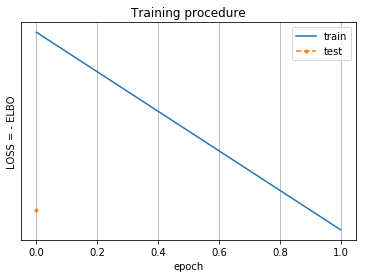

In [11]:
from matplotlib import pyplot as plt

plt.yscale('log')
y_shift=1000
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(train_loss)), np.array(train_loss)+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(train_loss), TEST_FREQUENCY), np.array(test_loss)+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(top = 760)
#plt.xlim(xmin = 0, xmax=700)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()


plt.savefig(write_dir+name_vae+'train.png')

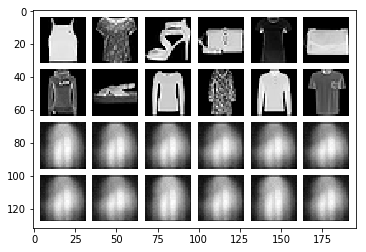

In [12]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
if(params['use_cuda']):
    imgs=imgs.cuda()
imgs_rec = vae.reconstruct(imgs)
show_2_batch(imgs[:12],imgs_rec[:12],npadding=4,nrow=6)
plt.savefig(write_dir+name_vae+'rec.png')

# compute the embedding

In [13]:
z_tot      = np.empty([0,params['DIM_Z']])
labels_tot = np.empty([0])
for data in testloader:
    if z_tot.shape[0] >= 6000:
        break

    imgs,labels = data
    if(params['use_cuda']):
        imgs=imgs.cuda()
    z = vae.encoder(imgs)

    z_tot = np.concatenate((z_tot, z.z_mu.view(-1,params['DIM_Z']).detach().cpu().numpy()),axis=0)
    labels_tot = np.concatenate((labels_tot, labels.numpy()),axis=0)

print("z_tot.shape",z_tot.shape)
print("labels_tot.shape",labels_tot.shape)

z_tot.shape (6144, 2)
labels_tot.shape (6144,)


# Clear the data

In [14]:
z_tot[np.isnan(z_tot)] = 0
z_tot[z_tot > 100] = 0
print(z_tot.shape)
print(z_tot[labels_tot==0].shape)
print(labels_tot.shape)

(6144, 2)
(614, 2)
(6144,)


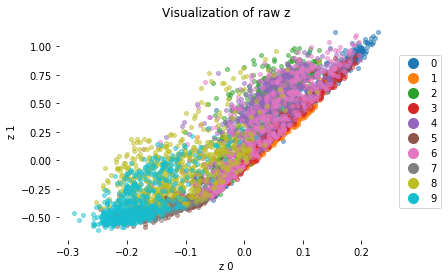

In [16]:
for k in np.unique(labels_tot):
    plt.plot(z_tot[labels_tot==k, 0], 
             z_tot[labels_tot==k, 1], '.', ms=8, alpha=0.5)

       
lgnd = plt.legend(np.unique(labels_tot).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('z 0')
plt.ylabel('z 1')
plt.title('Visualization of raw z')
plt.box(on=None)
plt.savefig(write_dir+name_vae+'raw_z.png')

In [18]:
cluster = dict()

for k in np.unique(labels_tot):
    mean_tmp = np.mean(z_tot[labels_tot == k],axis=0)
    #print(mean_tmp.shape)
    cluster[int(k)] = mean_tmp
cluster['all']=np.mean(z_tot,axis=0)
    

In [19]:
print(cluster)

{0: array([0.09069583, 0.45683568]), 1: array([0.05823829, 0.23075458]), 2: array([0.02203506, 0.37384838]), 3: array([0.06365203, 0.31081069]), 4: array([0.04114222, 0.45322937]), 5: array([-0.11250811, -0.37854815]), 6: array([0.0343013 , 0.32603587]), 7: array([-0.13462631, -0.42324835]), 8: array([-0.11056   , -0.05617342]), 9: array([-0.18084023, -0.35598223]), 'all': array([-0.02251635,  0.09625558])}


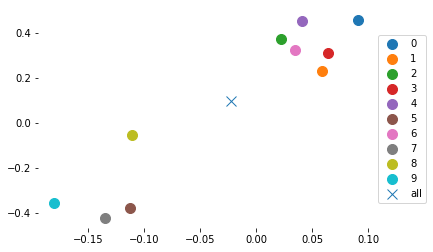

In [20]:

for key in range(10):
    mean = cluster[key]
    plt.plot(mean[0],mean[1],'.', ms=20, alpha=1,label=key)
plt.plot(cluster['all'][0],cluster['all'][1],'x', ms=10, alpha=1,label='all')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.box(on=None)
plt.savefig(write_dir+name_vae+'cluster_center.png')

In [22]:
# and I know this sounds ridiculous but we have to do more
# dimensionality reduction to visualize our dimensionality reduction

from sklearn.manifold import TSNE
z_tsne = TSNE(n_components=2).fit_transform(z_tot)

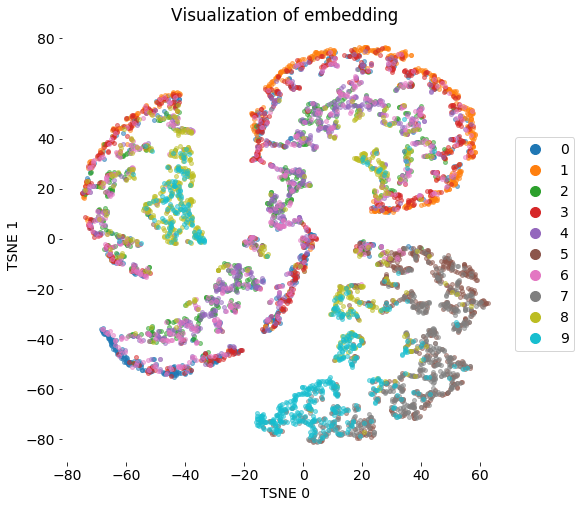

In [23]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8), frameon=False)
for k in np.unique(labels_tot):
    plt.plot(z_tsne[labels_tot==k, 0], 
             z_tsne[labels_tot==k, 1], '.', ms=8, alpha=0.5)

lgnd = plt.legend(np.unique(labels_tot).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('TSNE 0')
plt.ylabel('TSNE 1')
plt.title('Visualization of embedding')
plt.box(on=None)
plt.savefig(write_dir+name_vae+'embedding.png')